In [130]:
import numpy as np
import matplotlib.pyplot as plt # data visualization library
import math

If possible, update your sklearn version to 1.3.2 to reduce variance in the versions.

In [131]:
#!pip3 install scikit-learn==1.3.2

In [132]:
import sklearn
from sklearn import datasets
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.2.2.


# k-means initialization

In [133]:
!pip3 show numpy

Name: numpy
Version: 1.24.3
Summary: Fundamental package for array computing in Python
Home-page: https://www.numpy.org
Author: Travis E. Oliphant et al.
Author-email: 
License: BSD-3-Clause
Location: /home/ivt/.local/lib/python3.11/site-packages
Requires: 
Required-by: contourpy, matplotlib, pandas, patsy, scikit-learn, scipy, seaborn, statsmodels


The functions generating the datasets are given here:

In [134]:
def generateMoons(epsilon, n):
    moons, labels = sklearn.datasets.make_moons(n_samples=n, noise=epsilon, random_state=7)
    return "moons", moons, labels, 2
def generateBlobs(epsilon, n):
    blobs, labels = sklearn.datasets.make_blobs(n_samples=n,centers=3, cluster_std=[epsilon + 1, epsilon + 1.5, epsilon + 0.5], random_state=54)
    return "blobs", blobs, labels, 3

Implement the centroid initialization here. Right now, it returns a random initialization. 

In [135]:
# TODO: check these functions
def quadratic_dist(D, i, j):
    return np.sqrt(np.sum((D[i,:] - D[j,:])**2))

def sum_quadratic_dist(D, i):
    n,d = D.shape
    dist = np.sum([quadratic_dist(D, i, j) for j in np.delete(range(n), i)])
    return dist

def quadratic_closest(v, X):
    d_min = float('inf')
    i_min = -1
    for i, r in enumerate(X):
        d = np.sqrt(np.sum(v - r)**2)
        if d < d_min:
            d = d_min
            i_min = i
    return d_min


def init_centroids_greedy_pp(D,r,l=10):
    '''
        :param r: (int) number of centroids (clusters)
        :param D: (np-array) the data matrix
        :param l: (int) number of centroid candidates in each step
        :return: (np-array) 'X' the selected centroids from the dataset
    '''
    rng =  np.random.default_rng(seed=7) # use this random generator to sample the candidates (sampling according to given probabilities can be done via rng.choice(..))
    n,d = D.shape

    indexes = rng.integers(low=0, high=n, size=l) # 1.
    i_min = -1 # 2.
    d_min = float('inf')
    for i in indexes:
        d = sum_quadratic_dist(D, i)
        if d < d_min:
            i_min = i
            d_min = d
    X = np.array(D[i_min,:]).T # 3.
    for _ in range(r-1): # 5.
        p = np.zeros(n) # gather probabilities for 5.1
        s = np.sum([quadratic_closest(D[j,:].T, X) for j in range(n)])
        print(s)
        for i in range(n):
            p[i] = quadratic_closest(D[i,:].T, X) / s
        print(p)
        indexes = rng.choice(np.arange(n), size=l, p=p) # 5.1
        i_min = -1 # 5.2
        d_min = float('inf')
        for i in indexes:
            d = np.sum(quadratic_closest(D[j,:].T, np.column_stack(X, D[i,:].T)))
            if d < d_min:
                i_min = i
                d_min = d
        X = np.column_stack(X, D[i_min,:].T)
        
    return X

In [136]:
def spectral_clustering(W,r, X_init):
    '''
        :param W: (np-array) nxn similarity/weighted adjacency matrix
        :param r: (int) number of centroids (clusters)
        :param X_init: (function) the centroid initialization function 
        :return: (np-array) 'Y' the computed cluster assignment matrix
    '''  
    np.random.seed(0)
    L = np.diag(np.array(W.sum(0))[0]) - W
    v0 = np.random.rand(min(L.shape))
    Lambda, V = scipy.sparse.linalg.eigsh(L, k=r+1, which="SM", v0=v0)
    A = V[:,1:] #remove the first eigenvector, assuming that the graph is conected
    initial_points = X_init(A,r)
    X, Y = kmeans(A, r, initial_points)

    return Y

This is the $k$-means implementation from the lecture accompanying notebook.

In [137]:
def RSS(D,X,Y):
    return np.sum((D- Y@X.T)**2)
def getY(labels):
    '''
        Compute the cluster assignment matrix Y from the categorically encoded labels
    '''
    Y = np.eye(max(labels)+1)[labels]
    return Y
def update_centroid(D,Y):
    cluster_sizes = np.diag(Y.T@Y).copy()
    cluster_sizes[cluster_sizes==0]=1
    return D.T@Y/cluster_sizes
def update_assignment(D,X):
    dist = np.sum((np.expand_dims(D,2) - X)**2,1)
    labels = np.argmin(dist,1)
    return getY(labels)
def kmeans(D,r, X_init, epsilon=0.00001, t_max=10000):
    X = X_init.copy()
    Y = update_assignment(D,X)
    rss_old = RSS(D,X,Y) +2*epsilon
    t=0
    #Looping as long as difference of objective function values is larger than epsilon
    while rss_old - RSS(D,X,Y) > epsilon and t < t_max-1:
        rss_old = RSS(D,X,Y)
        X = update_centroid(D,Y)
        Y = update_assignment(D,X)
        t+=1
    print(t,"iterations")
    return X,Y

## Running k-means on the blobs dataset
We generate the blobs dataset. Run kmeans based on the initialization technique. Finally, we plot the clustering. The initial centroids are marked in red, and the final centroids are marked in blue. You can use this visualization to see if your initialization makes sense. It doesn't work for spectral clustering.

In [138]:
n=500
dataID, D, labels, r = generateBlobs(0.05,n)

In [139]:
X_init = init_centroids_greedy_pp(D,r)
X,Y = kmeans(D,r, X_init)

inf
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan na

/tmp/ipykernel_7117/1457903193.py:44: RuntimeWarning: invalid value encountered in scalar divide
  p[i] = quadratic_closest(D[i,:].T, X) / s


ValueError: probabilities contain NaN

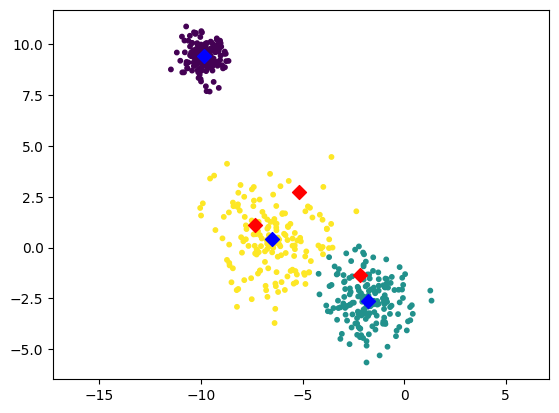

In [ ]:
fig = plt.figure()
ax = plt.axes()
ax.axis('equal')
ax.scatter(D[:, 0], D[:, 1], c=np.argmax(Y,axis=1), s=10)
ax.scatter(X_init.T[:, 0], X_init.T[:, 1], c='red', s=50, marker = 'D') # initial centroids are in red
ax.scatter(X.T[:, 0], X.T[:, 1], c='blue', s=50, marker = 'D') # computed centroids are in blue
plt.show()

## Running spectral clustering on the two moons dataset
We generate the moons dataset and compute spectral clustering with the implemented initialization technique.

In [ ]:
dataID, D, labels, r = generateMoons(0.05,n)

indexes:[472 312]
X:[[ 0.01839896  0.02829706]
 [-0.03676236 -0.03325734]]
4 iterations


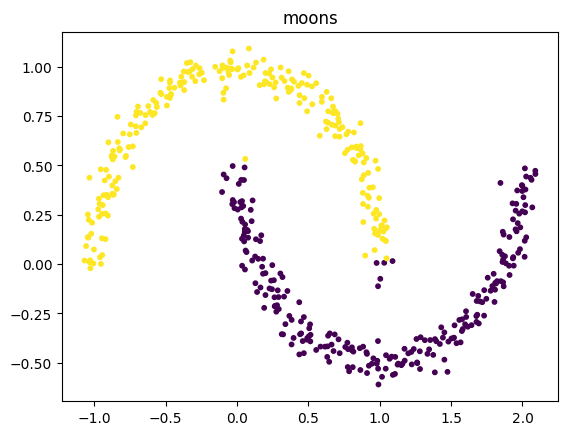

In [ ]:
from sklearn.neighbors import radius_neighbors_graph, kneighbors_graph
# Implement here the computation of W as knn graph
W = radius_neighbors_graph(D,0.5,include_self=False)
Y = spectral_clustering(W,r,init_centroids_greedy_pp)

plt.scatter(D[:, 0], D[:, 1], c=np.argmax(Y,axis=1), s=10)
plt.title('%s'  % ( dataID) )
plt.show()